In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, accuracy_score, plot_confusion_matrix, plot_roc_curve, classification_report
 
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-disease-dataset/heart.csv


# Load and Check Data

In [2]:
# Read data from CSV file and create a dataframe
df = pd.read_csv("/kaggle/input/heart-disease-dataset/heart.csv") 

In [3]:
# Display the first few rows of the dataframe
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [4]:
# Display the column names in the dataframe
df.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

In [5]:
# Display the dimensions of the dataframe
df.shape 

(1025, 14)

## Feature Description

**Features:**

1. age: age in years

2. sex: (1 = male; 0 = female)

3. cp: chest pain type (4 values)

4. trestbps: resting blood pressure (in mm Hg on admission to the hospital)

5. chol: serum cholestoral in mg/dl

6. fbs: fasting blood sugar > 120 mg/dl (1 = true, 0 = false)

7. restecg: resting electrocardiographic results (values 0,1,2)

8. thalach: maximum heart rate achieved

9. exang: exercise induced angina (1 = yes, 0 = no)

10. oldpeak: ST depression induced by exercise relative to rest

11. slope: the slope of the peak exercise ST segment (0,1,2)

12. ca: number of major vessels (0-3) colored by flourosopy

13. thal: 1 = normal, 2 = fixed defect, 3 = reversable defect

14. target: 0 = no disease, 1 = disease

In [6]:
# Display information about the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


**Categorical Features:** sex, cp, fbs, restecg, exang, slope, ca, thal


**Numerical Features:** age, trestbps, chol, thalach, oldpeak

In [7]:
# Define lists of categorical and numerical features
categorical_feature_list = ["sex", "cp", "fbs","restecg", "exang", "slope", 
                            "ca", "thal"] # categorical features

numerical_feature_list = ["age", "trestbps", "chol",
                          "thalach", "oldpeak"] # numerical features

# Data Analysis

In [8]:
# Check for null values in each column of dataframe
df.isnull().sum() 

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [9]:
# Remove rows with certain values in "ca" and "thal" columns
df.drop(df[df["ca"] == 4].index, inplace = True) 
df.drop(df[df["thal"] == 0].index, inplace = True) 

In [10]:
# Calculate basic statistics for each column in dataframe
df.describe() 

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,54.607000,0.691000,0.934000,131.592000,246.996000,0.146000,0.52400,148.977000,0.338000,1.092400,1.381000,0.701000,2.339000,0.508000
std,9.037822,0.462312,1.031847,17.714326,51.700802,0.353283,0.52887,23.083139,0.473265,1.180727,0.619857,0.944718,0.593659,0.500186
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.00000,71.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,48.000000,0.000000,0.000000,120.000000,211.000000,0.000000,0.00000,132.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,56.000000,1.000000,1.000000,130.000000,240.500000,0.000000,1.00000,152.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,277.000000,0.000000,1.00000,165.000000,1.000000,1.800000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.00000,202.000000,1.000000,6.200000,2.000000,3.000000,3.000000,1.000000


In [11]:
# Calculate mean value of "age" feature for target value
df[["target","age"]].groupby(["target"], as_index = False).mean().sort_values(by="target")

,target,age
0,0,56.689024
1,1,52.590551


In [12]:
# Calculate mean value of "trestbps" feature for target value
df[["target","trestbps"]].groupby(["target"], as_index = False).mean().sort_values(by="target")

,target,trestbps
0,0,134.168699
1,1,129.096457


In [13]:
# Calculate mean value of "thalach" feature for target value
df[["target","thalach"]].groupby(["target"], as_index = False).mean().sort_values(by="target")

,target,thalach
0,0,138.969512
1,1,158.669291


In [14]:
# Calculate mean value of "chol" feature for target value
df[["target","chol"]].groupby(["target"], as_index = False).mean().sort_values(by="target")

,target,chol
0,0,251.703252
1,1,242.437008


In [15]:
# Calculate mean value of "oldpeak" feature for target value
df[["target","oldpeak"]].groupby(["target"], as_index = False).mean().sort_values(by="target")

,target,oldpeak
0,0,1.614228
1,1,0.587008


* We see that numerical features are significantly different between target values, and we think that numerical features can help predict target values.

# Outlier Detection

In [16]:
# Function to detect outliers in dataset
def detect_outliers(df,features):
    outlier_indices = [] # Initialize list of outlier indices
    
    # Iterate over features
    for i in features:
        # Calculate 1st, 3rd quartiles and IQR
        Q1 = np.percentile(df[i],25) 
        Q3 = np.percentile(df[i],75) 
        IQR = Q3 - Q1 

        # Compute outlier step
        outlier_step = IQR * 1.5 

        # Determine indices of outliers in current feature
        outlier_list_col = df[(df[i] < Q1 - outlier_step) | (df[i] > Q3 + outlier_step)].index 

        # Append outlier indices to list
        outlier_indices.extend(outlier_list_col) 

    # Count number of outlier indices for each data point
    outlier_indices = Counter(outlier_indices)

    # Select rows with more than two outlier indices
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > 2) 

    # Return list of outlier indices
    return multiple_outliers

In [17]:
# Use function to find outliers in dataset
outlier_indices = detect_outliers(df, numerical_feature_list)
print("Outlier indices:", outlier_indices)

Outlier indices: []


# Data Visualization

## Target Visualization

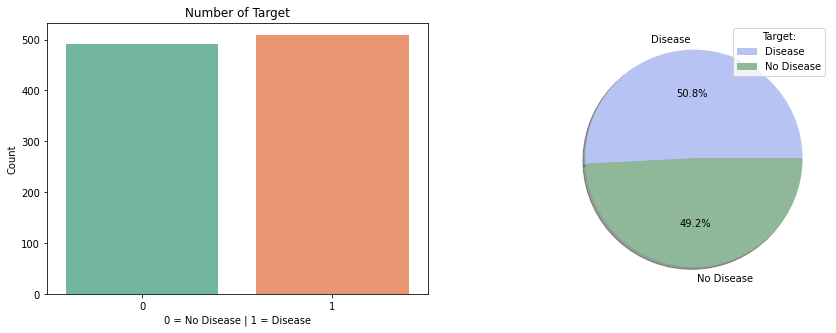

In [18]:
# Visualize number of target values in dataset
plt.figure(figsize=(15,5))

# Create bar plot showing count of target value
plt.subplot(1, 2, 1)
sns.countplot(x = "target", data = df, palette = "Set2")
plt.title("Number of Target")
plt.xlabel("0 = No Disease | 1 = Disease")
plt.ylabel("Count")

# Create pie chart showing proportion of target value
plt.subplot(1, 2, 2)
plt.pie(df["target"].value_counts(), labels = ["Disease", "No Disease"], shadow = True, autopct = "%1.1f%%", colors = ["#B7C3F3",  "#8EB897"])
plt.legend(title = "Target:")

# Display plots
plt.show()

* Data is balanced relative the target value.

## Categorical Feature Visualization

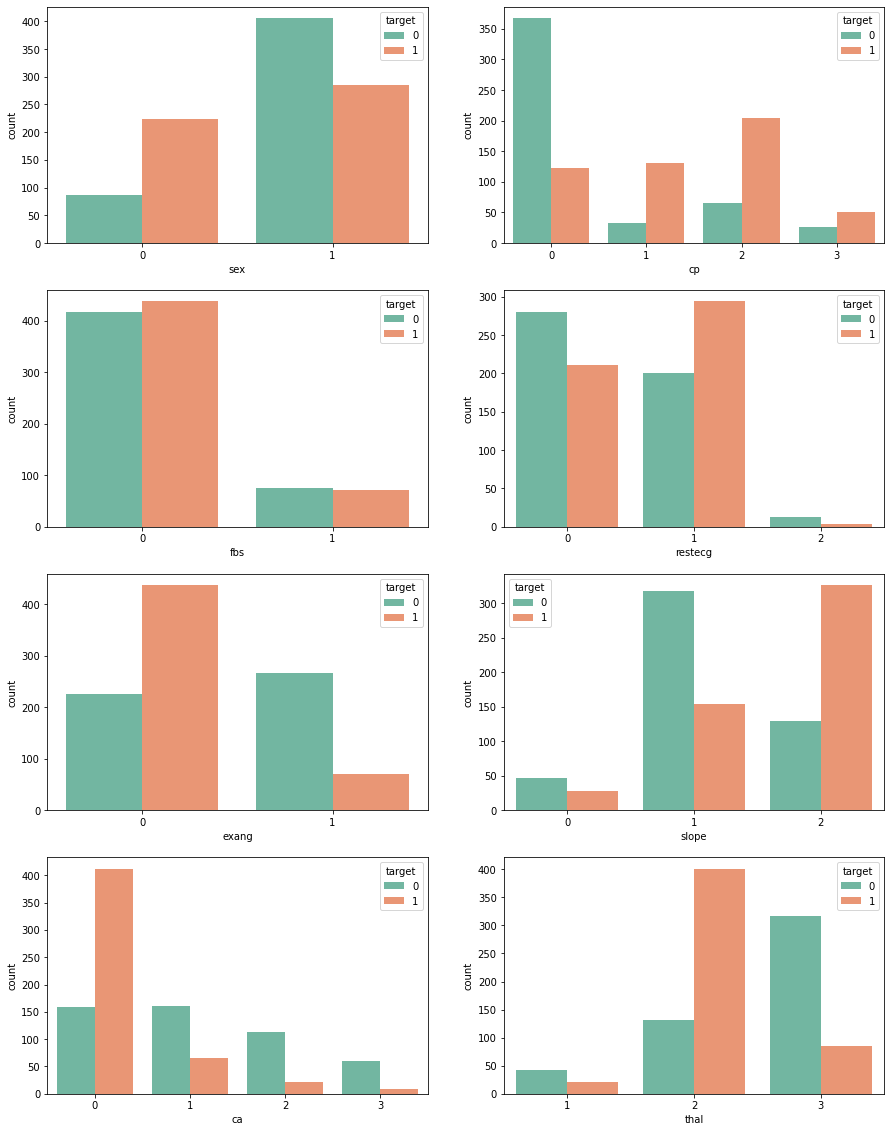

In [19]:
# Visualize distributions of categorical features by target value
i = 0
plt.figure(figsize=(15,20))

# Create plot for each categorical feature
for categorical_feature in categorical_feature_list:
    i += 1
    plt.subplot(4, 2, i)

    # Create countplot showing count of each category by target value
    sns.countplot(x = df[categorical_feature], data = df, hue = "target", palette = "Set2")

# Display plots    
plt.show()

* Women have a higher risk of heart disease than men.
* If cp -> typical angina the heart disease risk is very low.
* fbs may not be a distinctive feature for us.
* restecg -> 1 has a higher rate of heart disease than restecg -> 0 (There are few samples for restecg -> 2).
* exang -> 0 has a higher rate of heart disease than exang -> 1.
* slope -> 2 has a higher rate of heart disease than slope -> 1.
* ca -> 0, ca -> 1,2,3 It may be important to us because of the difference between.
* thal -> 2 has a higher rate of heart disease than thal -> 3.

## Numerical Feature Visualization

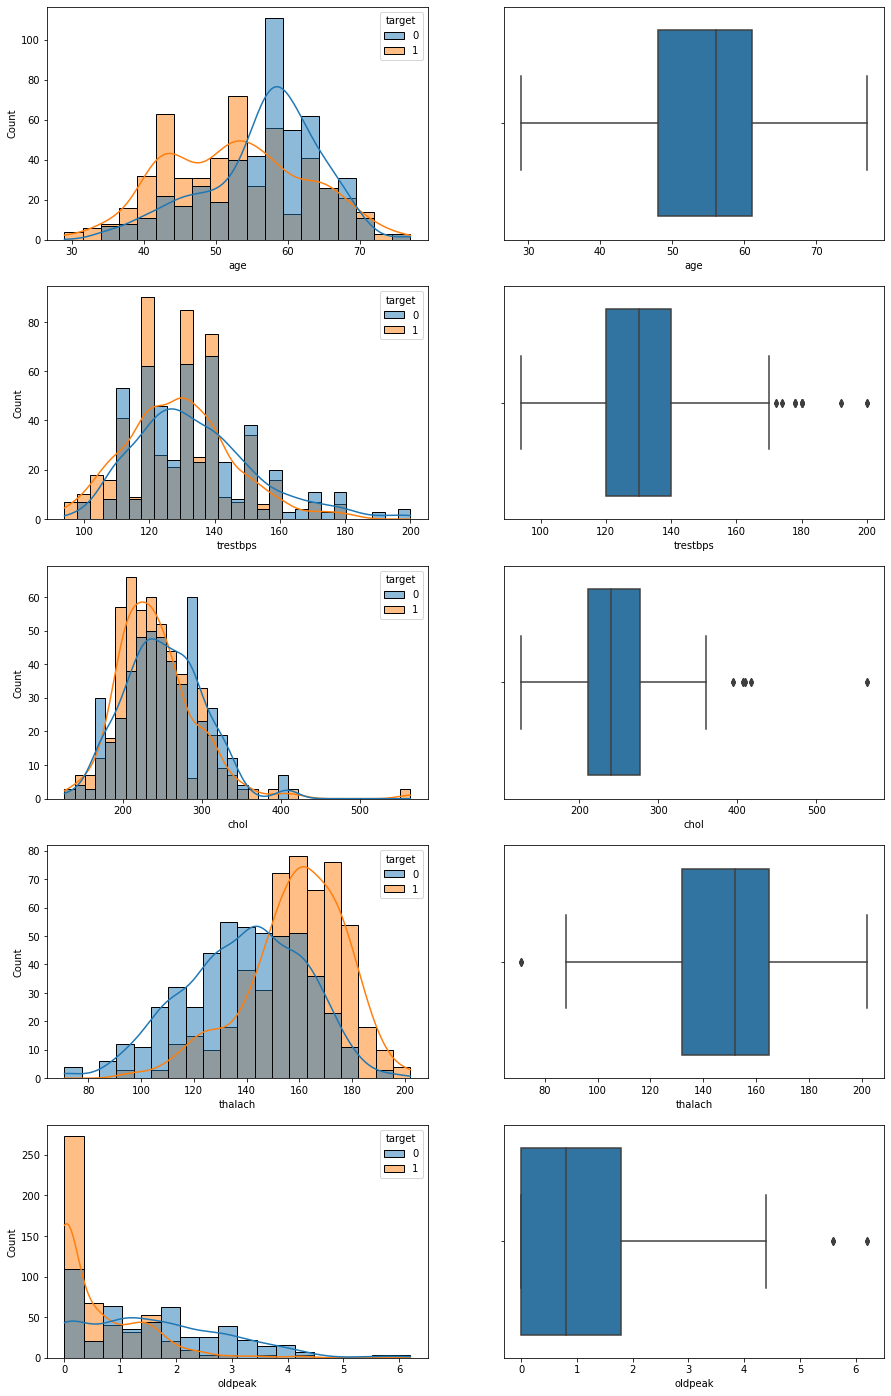

In [20]:
# Visualize distributions of numerical features by target value
i = 0
plt.figure(figsize=(15,30))

# Create two plots for each numerical feature
for numerical_feature in numerical_feature_list:

    i += 1
    plt.subplot(6, 2, i)
    # Create histogram showing distribution of feature values by target value
    sns.histplot(x = df[numerical_feature], data = df, kde = True, hue = "target")

    i += 1
    plt.subplot(6, 2, i)
    # Create boxplot showing distribution of feature values in general
    sns.boxplot(x = df[numerical_feature], data = df)
    
# Display plots   
plt.show()

* Data for oldpeak was found to be imbalanced.
* Some outliers were observed but we have already examined this situation in outlier detection.

## Correlation Matrix

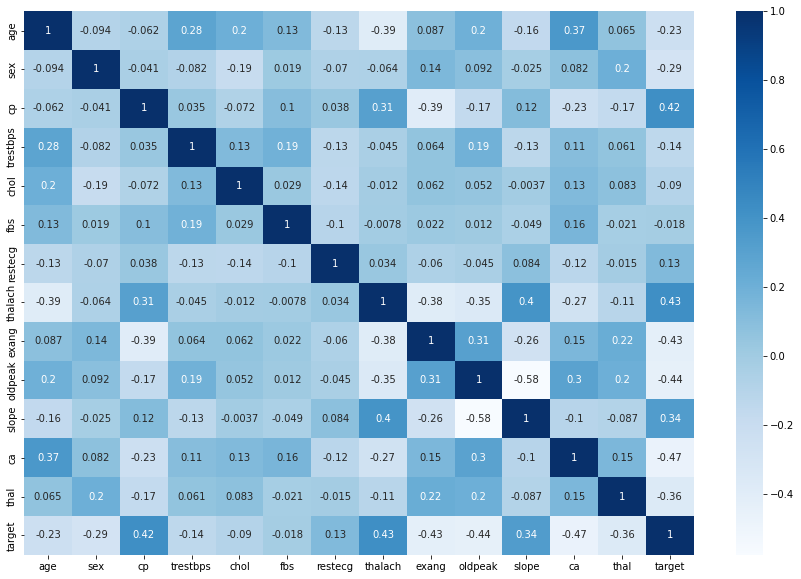

In [21]:
# Calculate correlation matrix for dataset
corr = df.corr()

# Create heatmap to visualize correlation matrix
plt.figure(figsize=(15,10))
sns.heatmap(corr, annot=True, cmap="Blues")

# Display heatmap
plt.show()

* target - cp, target - thalach, slope - thalach -> positive correlation

* ca - target, target - exang, oldpeak - target, slope - oldpeak -> negative correlation

# Feature Engineering

## Categorical Features

In [22]:
# Encode categorical features using the get_dummies function
df = pd.get_dummies(df, columns = categorical_feature_list)

* We converted categorical data to binary vector representations.

## Numerical Features

In [23]:
# Scale numerical features using the StandardScaler function
scaler = StandardScaler()
df[numerical_feature_list] = scaler.fit_transform(df[numerical_feature_list])

* The numeric values in the dataset were transformed to have a mean of 0 and a variance of 1.

# Modeling

## Splitting the Data

In [24]:
# Create variables for feature data and target values
X = df.drop(["target"], axis=1) # feature data
y = df["target"].values # target values

In [25]:
# Split dataset into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 128) # %70 train data, %30 test data

# Print lengths of training and testing datasets for each feature and target variable
print("X_train: ",len(X_train))
print("X_test: ",len(X_test))
print("y_train: ",len(y_train))
print("y_test: ",len(y_test))

X_train:  700
X_test:  300
y_train:  700
y_test:  300


## Model Training and Parameter Tuning 

In [26]:
# Set the random seed
random_state = 128 

# Define the machine learning models
model = [LogisticRegression(random_state = random_state),
         DecisionTreeClassifier(random_state = random_state),
         SVC(random_state = random_state, probability=True),
         RandomForestClassifier(random_state = random_state),
         KNeighborsClassifier(),
         GaussianNB()] 

# Define the list of class names
model_names = ["LogisticRegression",
               "DecisionTreeClassifier",
               "SVM",
               "RandomForestClassifier",
               "KNeighborsClassifier",
               "NaiveBayes"]

# Define the hyperparameter grids for each model
lr_params = {"C": [0.1, 1, 10, 100], 
             "penalty": ["l1", "l2"]} 

dt_params = {"min_samples_split" : range(10,50,20),
             "max_depth": range(1,10,2)} 

svm_params = {"kernel" : ["rbf"],
              "gamma": [0.001, 0.01, 0.1],
              "C": [1,10,50,100,200]} 

rf_params = {"n_estimators":[100,200,300,400]}

knn_params = {"n_neighbors": [1,2,3,4,5,6,7,8,9,10],
              "weights": ["uniform","distance"],
              "metric":["euclidean","manhattan"]} 

nb_params = {"var_smoothing": np.logspace(0,-9, num=100)} 

# Define a list of hyperparameter grids
param_grids = [lr_params,
               dt_params,
               svm_params,
               rf_params,
               knn_params,
               nb_params] 

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Machine Learning Models: LogisticRegression
Cross Validation Scores: 0.8671428571428571
Best Parameters: LogisticRegression(C=0.1, random_state=128)

-----------------------------------------------------

Train Accuracy of Classifier:  0.8685714285714285
Test Accuracy of Classifier:  0.87
The F1 Score of Classifier:  0.8704318936877077

-----------------------------------------------------

Classification Report: 
               precision    recall  f1-score   support

           0       0.93      0.82      0.87       159
           1       0.82      0.93      0.87       141

    accuracy                           0.87       300
   macro avg       0.87      0.87      0.87       300
weighted avg       0.88      0.87      0.87       300


-----------------------------------------------------

ROC Curve: 



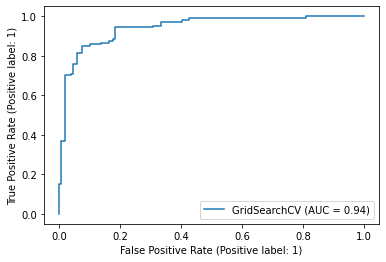


-----------------------------------------------------

Confusion Matrix: 



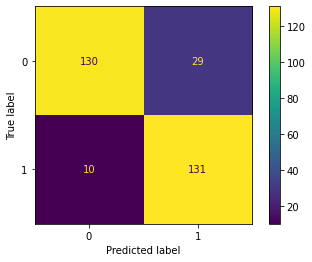


****************************************************************

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Machine Learning Models: DecisionTreeClassifier
Cross Validation Scores: 0.9042857142857142
Best Parameters: DecisionTreeClassifier(max_depth=9, min_samples_split=10, random_state=128)

-----------------------------------------------------

Train Accuracy of Classifier:  0.9771428571428571
Test Accuracy of Classifier:  0.9566666666666667
The F1 Score of Classifier:  0.9534050179211468

-----------------------------------------------------

Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.97      0.96       159
           1       0.96      0.94      0.95       141

    accuracy                           0.96       300
   macro avg       0.96      0.96      0.96       300
weighted avg       0.96      0.96      0.96       300


-----------------------------------------------------

ROC Curve: 



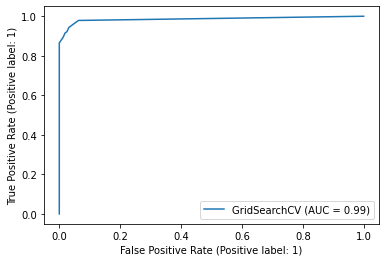


-----------------------------------------------------

Confusion Matrix: 



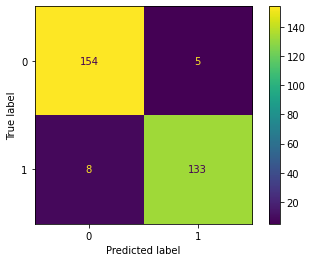


****************************************************************

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Machine Learning Models: SVM
Cross Validation Scores: 0.972857142857143
Best Parameters: SVC(C=50, gamma=0.1, probability=True, random_state=128)

-----------------------------------------------------

Train Accuracy of Classifier:  1.0
Test Accuracy of Classifier:  0.9666666666666667
The F1 Score of Classifier:  0.9642857142857143

-----------------------------------------------------

Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.97      0.97       159
           1       0.97      0.96      0.96       141

    accuracy                           0.97       300
   macro avg       0.97      0.97      0.97       300
weighted avg       0.97      0.97      0.97       300


-----------------------------------------------------

ROC Curve: 



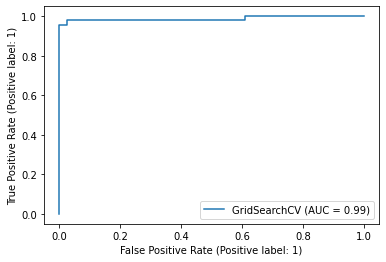


-----------------------------------------------------

Confusion Matrix: 



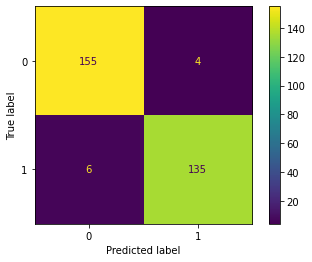


****************************************************************

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Machine Learning Models: RandomForestClassifier
Cross Validation Scores: 0.9842857142857143
Best Parameters: RandomForestClassifier(n_estimators=200, random_state=128)

-----------------------------------------------------

Train Accuracy of Classifier:  1.0
Test Accuracy of Classifier:  0.9866666666666667
The F1 Score of Classifier:  0.9860139860139859

-----------------------------------------------------

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.97      0.99       159
           1       0.97      1.00      0.99       141

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300


-----------------------------------------------------

ROC Curve: 



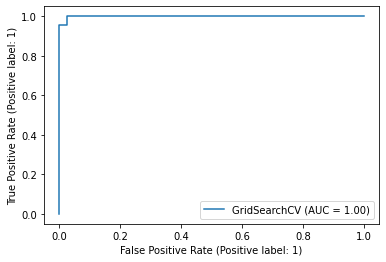


-----------------------------------------------------

Confusion Matrix: 



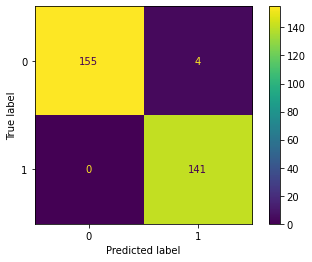


****************************************************************

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Machine Learning Models: KNeighborsClassifier
Cross Validation Scores: 0.9871428571428572
Best Parameters: KNeighborsClassifier(metric='manhattan', n_neighbors=8, weights='distance')

-----------------------------------------------------

Train Accuracy of Classifier:  1.0
Test Accuracy of Classifier:  0.9866666666666667
The F1 Score of Classifier:  0.9860139860139859

-----------------------------------------------------

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.97      0.99       159
           1       0.97      1.00      0.99       141

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300


-----------------------------------------------------

ROC Curve: 



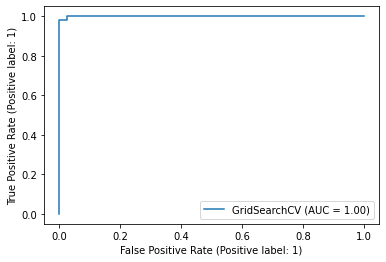


-----------------------------------------------------

Confusion Matrix: 



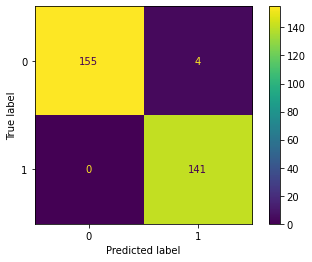


****************************************************************

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Machine Learning Models: NaiveBayes
Cross Validation Scores: 0.8457142857142858
Best Parameters: GaussianNB(var_smoothing=0.02848035868435802)

-----------------------------------------------------

Train Accuracy of Classifier:  0.8457142857142858
Test Accuracy of Classifier:  0.8533333333333334
The F1 Score of Classifier:  0.8533333333333334

-----------------------------------------------------

Classification Report: 
               precision    recall  f1-score   support

           0       0.91      0.81      0.85       159
           1       0.81      0.91      0.85       141

    accuracy                           0.85       300
   macro avg       0.86      0.86      0.85       300
weighted avg       0.86      0.85      0.85       300


-----------------------------------------------------

ROC Curve: 



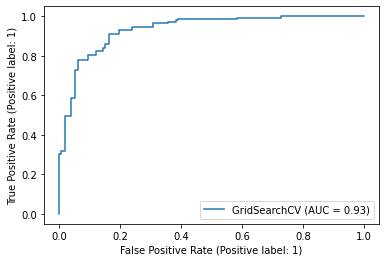


-----------------------------------------------------

Confusion Matrix: 



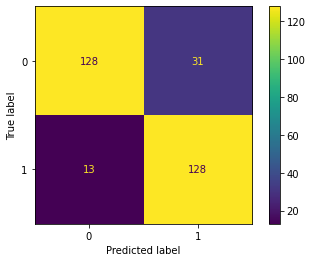


****************************************************************



In [27]:
# Define two list to store the results and estimators
cv_result = []
best_estimators = []

# Iterate over the models and their hyperparameter grids
for i in range(len(model)):

    # Define the stratified K-fold cross-validation scheme
    cv = StratifiedKFold(n_splits = 5)
    
    # Define the grid search strategy
    clf = GridSearchCV(model[i], 
                       param_grid=param_grids[i], 
                       cv = cv, 
                       scoring = "accuracy", 
                       n_jobs = -1,
                       verbose = 1)
    
    # Print the cross validation score, best parameters and the train and test accuracy of the model
    clf.fit(X_train,y_train)
    cv_result.append(clf.best_score_)
    best_estimators.append(clf.best_estimator_)

    print("Machine Learning Models:", model_names[i])
    print("Cross Validation Scores:", cv_result[i])
    print("Best Parameters:", best_estimators[i])
    print("\n-----------------------------------------------------\n")

    print("Train Accuracy of Classifier: ", accuracy_score(clf.predict(X_train),y_train))
    print("Test Accuracy of Classifier: ", accuracy_score(clf.predict(X_test),y_test))
    print("The F1 Score of Classifier: ", f1_score(clf.predict(X_test), y_test))
    print("\n-----------------------------------------------------\n")

    # Print the classification report and plot the ROC curve and confusion matrix
    print("Classification Report: \n", classification_report(y_test, clf.predict(X_test)))
    print("\n-----------------------------------------------------\n")
    
    print("ROC Curve: \n")
    plot_roc_curve(clf, X_test, y_test)
    plt.show()
    print("\n-----------------------------------------------------\n")

    print("Confusion Matrix: \n")
    plot_confusion_matrix(clf, X_test, y_test)
    plt.show()
    print("\n****************************************************************\n")
    

## Model Evaluation

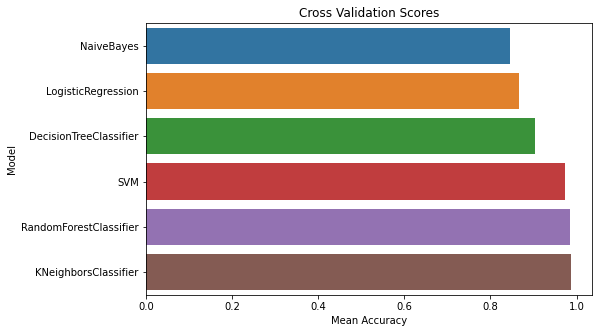

In [28]:
# Create dataframe with mean accuracy scores for each model
cv_results = pd.DataFrame({"Cross Validation Means":cv_result, 
                           "Model":["LogisticRegression",
                                    "DecisionTreeClassifier", 
                                    "SVM",
                                    "RandomForestClassifier",
                                    "KNeighborsClassifier",
                                    "NaiveBayes"]}).sort_values(by="Cross Validation Means")

# Create barplot to visualize mean accuracy scores for each model
plt.figure(figsize=(8,5))
g = sns.barplot("Cross Validation Means", "Model", data = cv_results)

# Set x-axis label and plot title
g.set_xlabel("Mean Accuracy")
g.set_title("Cross Validation Scores")

# Display plot
plt.show()

* Considering the relations between the features in our data set and this table, it was concluded that the best algorithm is the KNN algorithm.